# COGS 108 - EDA Checkpoint

# Names

- Hugs Clorina
- John Howell
- Andy Chow
- Jawad Osman
- Vince Ermitano

<a id='research_question'></a>
# Research Question

Is there a statistically significant correlation between rising ocean temperature and sea level with the frequency of unprovoked shark attacks in North America?

# Setup

In [44]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# import pandas & numpy library
import pandas as pd
import numpy as np

# import datetime for date parsing
from datetime import datetime, timedelta

# import patsy and statsmodels for linear regression
import patsy
import statsmodels.api as sm

from scipy import stats

In [45]:
# read in all datasets
sharks_df = pd.read_csv("./shark_attacks.csv")
temp_df = pd.read_csv("./temperature_anomalies.csv")
sl_pacific_df = pd.read_csv("./sea_level_north_pacific.csv")
sl_atlantic_df = pd.read_csv("./sea_level_north_atlantic.csv")

# Data Cleaning

## Shark attack

The data that needs the most cleaning work done is the shark attack data because
- it contains columns that are irrelevant to our research or revealed personal information
- it contains shark attacks in regions/areas of the world that are not relevant to our scope.
- it contains rows for *provoked* shark attacks when we are really trying to research relative to *unprovoked* shark attacks
- it is missing categorization of areas of attacks between East and West Coast

Thus, pertaining to the shark attack data, we cleaned up our data as follows:
1. read in the shark attack csv file
2. filtered the dataset to only areas that we of interest (North America)
    * looked at all unique values for countries
    * defined which of these values to retain
    * dropped rows for values in which don't exist in our area of interest
3. filtered the dataset to only include rows that had their 'Type' column value as 'unprovoked'
4. dropped columns that were either irrelevant or included personal data
5. categorized the areas into East and West Coast appropriately

In [46]:
# get a feel for the data
print(sharks_df.shape)
print(sharks_df.columns)

(25847, 24)
Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')


In [47]:
# look at all unique countries
print(sharks_df['Country'].unique())

# filter by area, unprovoked attacks, and relevant year frame
sharks_df = sharks_df[sharks_df['Country'] == 'USA']
sharks_df = sharks_df[sharks_df['Type'] == 'Unprovoked']
sharks_df = sharks_df[sharks_df['Year'] >= 1880]

# drop irrelevant or ethically exposing columns
sharks_df = sharks_df.drop(columns=['Investigator or Source', 'Injury', 'Time', 'pdf','Species ', 'href formula', 'Name', 'Unnamed: 22', 'Unnamed: 23', 'Case Number.1', 'Case Number.2', 'href', 'original order']).reset_index(drop=True)

['USA' 'BAHAMAS' 'AUSTRALIA' 'SOUTH AFRICA' 'ENGLAND' 'JAPAN' 'INDONESIA'
 'EGYPT' 'JA MAICA' 'BELIZE' 'MALDIVES' 'FRENCH POLYNESIA' 'THAILAND'
 'COLUMBIA' 'NEW ZEALAND' 'MEXICO' 'COSTA RICA' 'New Zealand' 'BRAZIL'
 'British Overseas Territory' 'CANADA' 'ECUADOR' 'JORDAN' 'NEW CALEDONIA'
 'JAMAICA' 'ST KITTS / NEVIS' 'ST MARTIN' 'SPAIN' 'FIJI' 'SEYCHELLES'
 'PAPUA NEW GUINEA' 'REUNION ISLAND' 'ISRAEL' 'CHINA' 'SAMOA' 'IRELAND'
 'ITALY' 'COLOMBIA' 'MALAYSIA' 'LIBYA' nan 'CUBA' 'MAURITIUS'
 'SOLOMON ISLANDS' 'ST HELENA, British overseas territory' 'COMOROS'
 'REUNION' 'UNITED KINGDOM' 'UNITED ARAB EMIRATES' 'PHILIPPINES'
 'CAPE VERDE' 'Fiji' 'DOMINICAN REPUBLIC' 'CAYMAN ISLANDS' 'ARUBA'
 'MOZAMBIQUE' 'PUERTO RICO' 'ATLANTIC OCEAN' 'GREECE' 'ST. MARTIN'
 'FRANCE' 'TRINIDAD & TOBAGO' 'KIRIBATI' 'DIEGO GARCIA' 'TAIWAN'
 'PALESTINIAN TERRITORIES' 'GUAM' 'NIGERIA' 'TONGA' 'SCOTLAND' 'CROATIA'
 'SAUDI ARABIA' 'CHILE' 'ANTIGUA' 'KENYA' 'RUSSIA' 'TURKS & CAICOS'
 'UNITED ARAB EMIRATES (UAE)' 'AZ

In [48]:
# categorize 'Area' column values to 'East Coast' or 'West Coast'
print(sharks_df['Area'].unique())

west_coast = ['California', 'Hawaii', 'Texas', 'Oregon', 'Guam', 'Maui', 'Baja ', 'Guerrero',
              'Washington', 'Baja California Sur', 'Palmyra Atoll', 'Johnston Atoll', 'Midway Atoll']

east_coast = ['Louisiana', 'South Carolina', 'Florida','New York', 'Noirth Carolina', 'Alabama',
              'Maryland', 'North Carolina', 'Georgia', 'Franklin County, Florida', 'Virgin Islands',
              'Maine', 'Bahamas', 'Cayman Islands', 'Rhode Island', 'New Jersey', 'Massachusetts', 'Delaware',
              'Virginia', 'Puerto Rico', 'US Virgin Islands', 'South Carolina ', 'Connecticut', 'Mississippi',
              'Wake Island', ' North Carolina', 'East coast']

['California' 'Hawaii' 'Louisiana' 'South Carolina' 'Florida' 'New York'
 'Noirth Carolina' 'Alabama' 'Texas' 'Maryland' 'North Carolina' 'Georgia'
 'Oregon' 'Franklin County, Florida' 'Virgin Islands' 'Maine' 'Bahamas'
 'Maui' 'Guam' 'Cayman Islands' 'Rhode Island' 'New Jersey'
 'Massachusetts' 'Washington' 'Delaware' 'Palmyra Atoll' 'Puerto Rico'
 'Virginia' 'US Virgin Islands' 'South Carolina ' 'Johnston Atoll'
 'Connecticut' 'Mississippi' 'Wake Island' ' North Carolina'
 'Midway Atoll' 'East coast']


In [49]:
def categorize_east_west(str_in):
    if str_in in west_coast:
        return 'West Coast'
    return 'East Coast'

sharks_df['West/East Coast'] = sharks_df['Area'].apply(categorize_east_west)

In [50]:
# take a look at our cleaned-up shark data
sharks_df.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
0,2022.10.31,31-Oct-2022,2022.0,Unprovoked,USA,California,"Otter Point, Pacific Grove",Surfing,M,NaN,N,West Coast
1,2022.10.25,25 Oct-2022,2022.0,Unprovoked,USA,Hawaii,Kauai,Snorkeling,M,51,N,West Coast
2,2022.10.08,08-Oct-2022,2022.0,Unprovoked,USA,Louisiana,25 miles off Empire,Shipwreck,M,40,N,East Coast
3,2022.010.02,02-Oct-2022,2022.0,Unprovoked,USA,California,Centerville Beach,Surfing,M,31,N,West Coast
4,2022.09.03,03-Sep-2022,2022.0,Unprovoked,USA,Hawaii,"Lower Paia Beach Park, Maui",Swimming or Snorkeling,F,51,N,West Coast


In [51]:
sharks_df.dtypes

Case Number         object
Date                object
Year               float64
Type                object
Country             object
Area                object
Location            object
Activity            object
Sex                 object
Age                 object
Fatal (Y/N)         object
West/East Coast     object
dtype: object

Here, we parse the dates.
Note:
1. There are cases with reported date. They are in the format `'Reported 01-Jan-2022'`. We acknowledge that the date provided here might not be accurate.
2. If date is None, it means that the case has no exact date. e.g. only provided year, season, month, etc. The full list of rejected entries are printed below.

In [52]:
def string_to_date(str_in):
    try:
        # clean up entries
        str_in  = str_in.replace('Reported','')
        str_in = str_in.strip(' .abcde')
        str_in  = str_in.replace(' ','-')
        str_in  = str_in.replace('--','-')

        # Handle edge cases
        if str_in in ['20-May2015', '13-May2014', '29-Nov2013']:
            return datetime.strptime(str_in, '%d-%b%Y')
        if str_in == '12-Jul-1913':  # Checked case number, year is 2020
            str_in = '12-Jul-1913'
        if str_in == '10-Jul-202':  # Checked case number, year is 2020
            str_in = '10-Jul-2020'

        return datetime.strptime(str_in, '%d-%b-%Y')
    except ValueError:
        print(str_in)
        return None

# TODO: not applied to the main df
sharks_df['Date'].apply(string_to_date)

May-2016
2014
Apr-2013
Jun-2010
Sep-2008
Aug-2006
July-2006
July-2006
Sep-2003
Jul-2003
Jul-2001
Mar-2000
1998
1996
1995
1994
Dec-1993
Oct-1993
Jun-1993
1993
Sep-1992
July-1991
1990
Apr-1989
1989
Oct-1988
Oct-1986
Sep-1986
Sep-1986
1986
1984
Nov-1982
Late-Jul-1980
Early-Jul-1980
1979
1978
1976
Sep-1974
1971
Oct-1970
Sep-1970
Sep-1970
Jun-1969
Aug-1966
Summer-1965
Feb-1964
Oct-1961
Aug-1960
Jul-1958
May-1957
Feb-1957
1957
1957
1956
Apr-1955
1955
1954
1953
1952
Jul-1950
1950
Fall-1943
Fall-1943
1943
1929
Sep-1928
Nov-1925
Nov-1925
May-1925
Feb-1923
1919
Nov-1918
12-July-1913
1911
Jul-1907
1907
Late-Aug-1905
Jul-1905
1904
Ca.-1903
Summer-1901
Early-1900s
Ca.-1899
1898
1898-1899
1896
Summer-of-1883
1883
1882


0      2022-10-31
1      2022-10-25
2      2022-10-08
3      2022-10-02
4      2022-09-03
          ...    
1855          NaT
1856          NaT
1857   1881-09-05
1858   1881-08-12
1859   1881-06-13
Name: Date, Length: 1860, dtype: datetime64[ns]

Here, we parse the ages.
Note:
1. Some ages uses age range, e.g. mid-30s, 60s, here, we use x+5 for 'mid-x's' and x for 'x's'
2. When dealing with ambiguous ages (12 or 13, 21 or 26), we take the average of the 2 ages.
3. We decided not to include ages of cases with multiple victims. However, we will be keeping the cases.
4. If age is None, it means that:
    1. no age is given, in the case of Nan;
    2. no exact age is given. e.g. teen, minor, elderly, etc;
    3. the case has multiple victims; or
    4. the age is invalid or too ambiguous to parse. e.g. `!6, !!`

The full list of rejected entries are printed below.

In [53]:
def age_to_float(age_in):
    if type(age_in) is float:  # Nan here is float
        return age_in

    try:
        age_in = age_in.strip(' \'s')
        if 'mid' in age_in:
            age_in.replace('mid-', '')
            return float(age_in) + 0.5

        if ' or ' in age_in:
            age1, age2 = age_in.split(' or ')
            return (float(age1) + float(age2)) / 2

        # Handle edge cases
        if age_in == '6½':
            return 6.5

        return float(age_in)
    except ValueError:
        print(age_in)
        return None

# TODO: Cases with multiple victims not accounted for
sharks_df['Age'] = sharks_df['Age'].apply(age_to_float)

teen
Teen
!6
!!
Teen
22, 57, 31
a minor
Teen
Teen
Teen
teen
teen
teen
Teen
teen
mid-30
Elderly
9 & 12


In [54]:
sharks_df['Year'] = sharks_df['Year'].astype(int)
sharks_df['Fatal (Y/N)'] = sharks_df['Fatal (Y/N)'].str.replace('Nq', 'N')

# Now all case in the data are unprovoked, 'Type' column is not necessary
sharks_df = sharks_df.drop(columns=['Type'])

sharks_df

,Case Number,Date,Year,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
0,2022.10.31,31-Oct-2022,2022,USA,California,"Otter Point, Pacific Grove",Surfing,M,NaN,N,West Coast
1,2022.10.25,25 Oct-2022,2022,USA,Hawaii,Kauai,Snorkeling,M,51.0,N,West Coast
2,2022.10.08,08-Oct-2022,2022,USA,Louisiana,25 miles off Empire,Shipwreck,M,40.0,N,East Coast
3,2022.010.02,02-Oct-2022,2022,USA,California,Centerville Beach,Surfing,M,31.0,N,West Coast
4,2022.09.03,03-Sep-2022,2022,USA,Hawaii,"Lower Paia Beach Park, Maui",Swimming or Snorkeling,F,51.0,N,West Coast
...,...,...,...,...,...,...,...,...,...,...,...
1855,1883.00.00.a,1883,1883,USA,South Carolina,NaN,NaN,M,NaN,Y,East Coast
1856,1882.00.00.b,1882,1882,USA,Florida,"In the bay near the naval yard at Pensacola, E...","During ""an exhibition"" he was tied in sack & t...",M,NaN,N,East Coast
1857,1881.09.05,05-Sep-1881,1881,USA,North Carolina,"Elizabeth City, Pasquotank County",Bathing,M,NaN,Y,East Coast
1858,1881.08.12,12-Aug-1881,1881,USA,Rhode Island,Providence,Swimming,M,NaN,N,East Coast


## Ocean temperature anomalies

For the remaining datasets (sea_level & temperature_anomalies), most of the data we already clean so we only made the following changes:
1. Removed first 4 rows in the ocean temperature dataset because it stored irrelevant data.
2. The intial column names in the ocean temperature dataset did not make sense for the values that are stored, so we changed the column names to appropriate titles (Year, Temperature Anomaly (Celsius))
3. Change data types from string to int(for year) or float(for temperature anomaly)

In [55]:
# get a feel for the data
print(temp_df.shape)
print(temp_df.columns)

temp_df.head()

(146, 2)
Index(['Northern Hemisphere Ocean Temperature Anomalies', ' January-December'], dtype='object')


,Northern Hemisphere Ocean Temperature Anomalies,January-December
0,Units: Degrees Celsius,NaN
1,Base Period: 1901-2000,NaN
2,Missing: -999,NaN
3,Year,Value
4,1880,-0.02


In [56]:
# need to remove unnecessary initial rows (0-4)
temp_df = temp_df.loc[4:].reset_index(drop=True)

# rename column titles appropriately
temp_df = temp_df.rename(columns={'Northern Hemisphere Ocean Temperature Anomalies': 'year', ' January-December': 'temperature_anomaly_cel'})

temp_df.head()

,year,temperature_anomaly_cel
0,1880,-0.02
1,1881,-0.02
2,1882,-0.03
3,1883,-0.08
4,1884,-0.16


In [57]:
temp_df.dtypes

year                       object
temperature_anomaly_cel    object
dtype: object

In [58]:
temp_df['year'] = temp_df['year'].astype(int)
temp_df['temperature_anomaly_cel'] = temp_df['temperature_anomaly_cel'].astype(float)
temp_df.dtypes

year                         int64
temperature_anomaly_cel    float64
dtype: object

## Sea Level

The sea level data we already clean, so we just read the dataset in with no modifications

In [59]:
# northern pacific sea level data
print(sl_pacific_df.shape)
sl_pacific_df.head()

(1375, 5)


,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992.9611,13.06,NaN,NaN,NaN
1,1992.9865,-4.77,NaN,NaN,NaN
2,1993.0126,-3.39,NaN,NaN,NaN
3,1993.0408,-20.67,NaN,NaN,NaN
4,1993.0659,-31.04,NaN,NaN,NaN


In [60]:
# northern atlantic sea level data
print(sl_atlantic_df.shape)
sl_atlantic_df.head()

(1378, 5)


,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992.9620,-17.99,NaN,NaN,NaN
1,1992.9873,-9.87,NaN,NaN,NaN
2,1993.0129,-17.22,NaN,NaN,NaN
3,1993.0413,-0.27,NaN,NaN,NaN
4,1993.0667,-19.85,NaN,NaN,NaN


In [61]:
# While decimal year is useful for linear regression, we want to add a column of dates for easier reading
def decimal_year_to_date(year_in):
    year_out = int(year_in)
    year_begin = datetime(year_out, 1, 1)
    year_end = datetime(year_out + 1, 1, 1)
    fraction = year_in - year_out
    result = year_begin + timedelta(seconds=(year_end - year_begin).total_seconds() * fraction)
    return result.date()

In [62]:
pacific_col = sl_pacific_df['year'].apply(decimal_year_to_date)
sl_pacific_df_view = sl_pacific_df.copy()
sl_pacific_df_view.insert (0, "date", pacific_col)

atlantic_col = sl_atlantic_df['year'].apply(decimal_year_to_date)
sl_atlantic_df_view = sl_atlantic_df.copy()
sl_atlantic_df_view.insert (0, "date", atlantic_col)

sl_pacific_df_view.head()

,date,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992-12-17,1992.9611,13.06,NaN,NaN,NaN
1,1992-12-27,1992.9865,-4.77,NaN,NaN,NaN
2,1993-01-05,1993.0126,-3.39,NaN,NaN,NaN
3,1993-01-15,1993.0408,-20.67,NaN,NaN,NaN
4,1993-01-25,1993.0659,-31.04,NaN,NaN,NaN


In [63]:
sl_atlantic_df_view.head()

,date,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992-12-18,1992.9620,-17.99,NaN,NaN,NaN
1,1992-12-27,1992.9873,-9.87,NaN,NaN,NaN
2,1993-01-05,1993.0129,-17.22,NaN,NaN,NaN
3,1993-01-16,1993.0413,-0.27,NaN,NaN,NaN
4,1993-01-25,1993.0667,-19.85,NaN,NaN,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

<AxesSubplot: xlabel='year', ylabel='sl-change'>

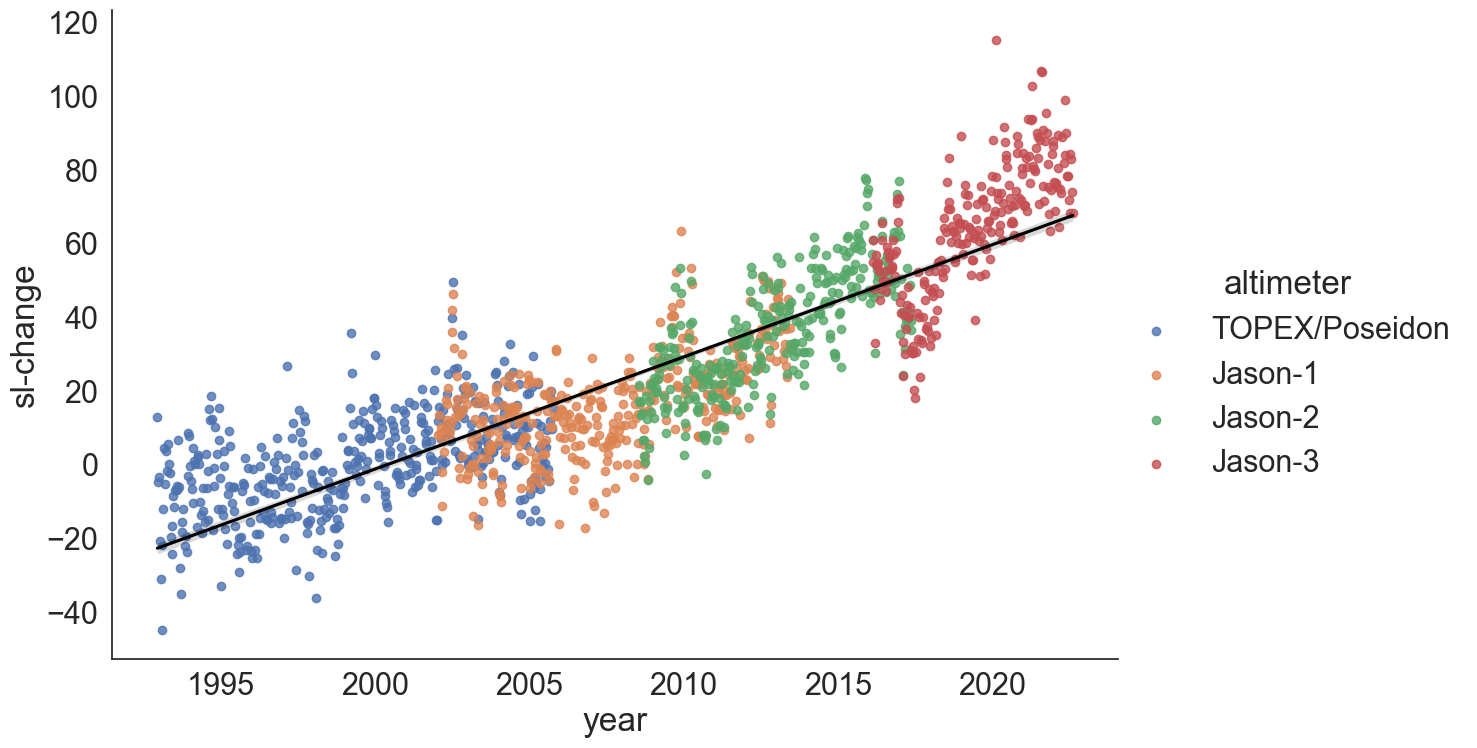

In [64]:
dfm = sl_pacific_df.melt('year', var_name='altimeter', value_name='sl-change')
fig_a1 = sns.lmplot(data=dfm, x='year', y='sl-change', hue='altimeter', hue_order=['TOPEX/Poseidon','Jason-1','Jason-2','Jason-3'], height=8, aspect=1.5, fit_reg=False)
sns.regplot(data=dfm, x='year', y='sl-change', scatter=False, ax=fig_a1.axes[0, 0], color='black')

<AxesSubplot: xlabel='year', ylabel='sl-change'>

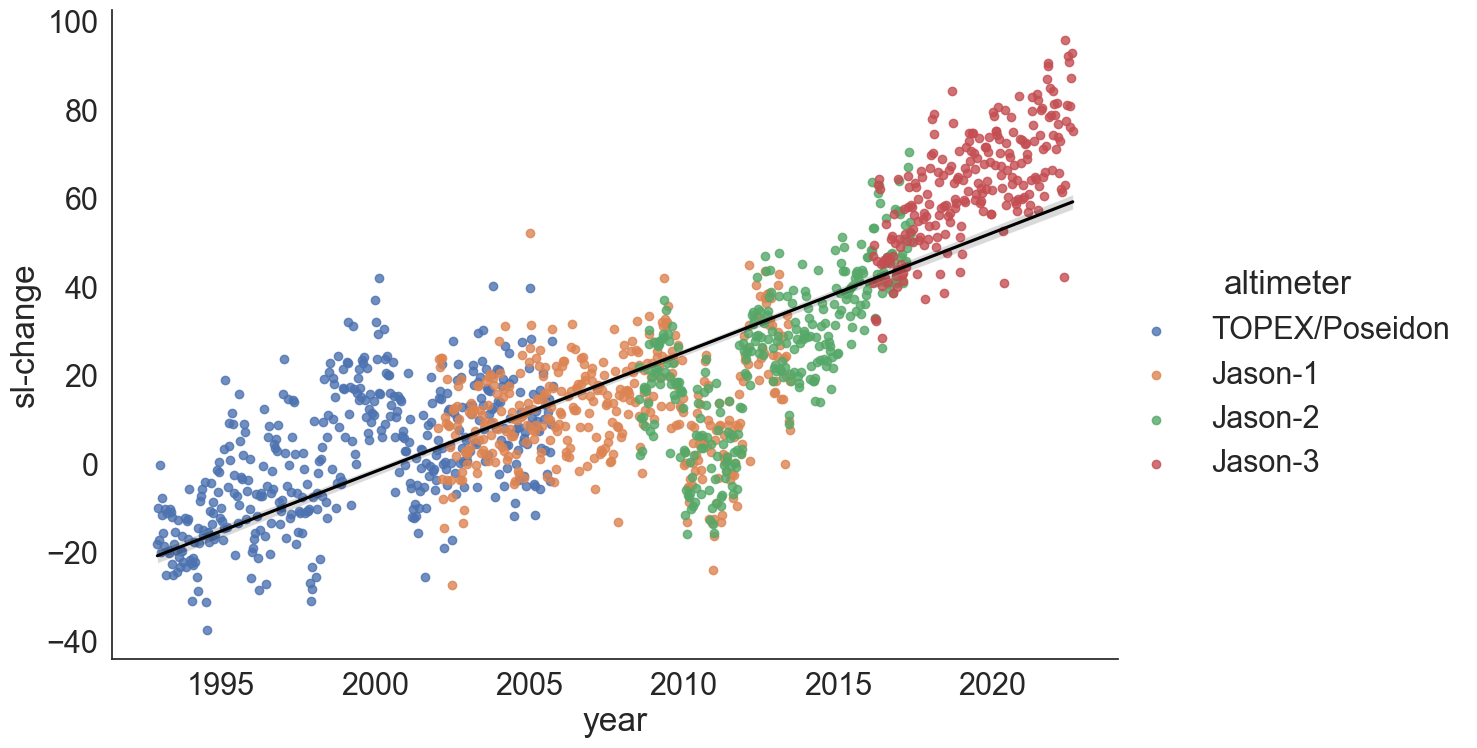

In [65]:
dfm = sl_atlantic_df.melt('year', var_name='altimeter', value_name='sl-change')
fig_a2 = sns.lmplot(data=dfm, x='year', y='sl-change', hue='altimeter', hue_order=['TOPEX/Poseidon','Jason-1','Jason-2','Jason-3'], height=8, aspect=1.5, fit_reg=False)
sns.regplot(data=dfm, x='year', y='sl-change', scatter=False, ax=fig_a2.axes[0, 0], color='black')

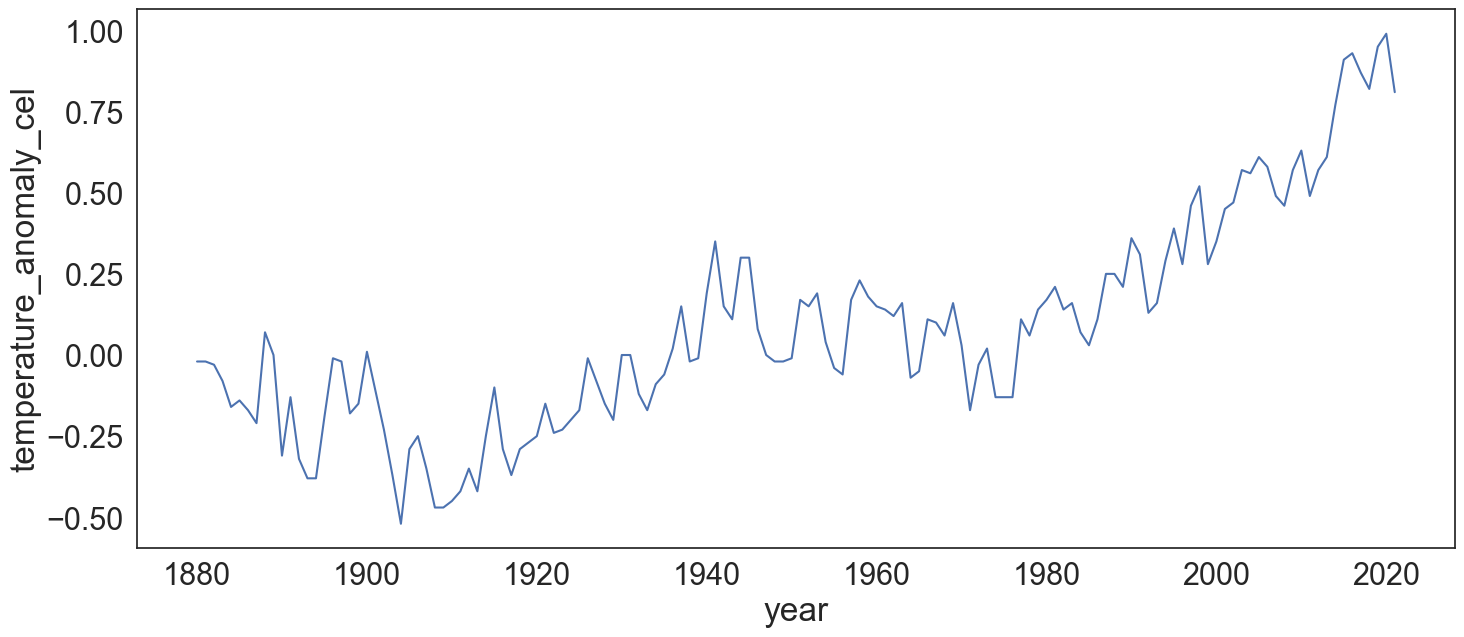

In [66]:
fig_a3 = sns.lineplot(data=temp_df, x='year', y='temperature_anomaly_cel')

<AxesSubplot: xlabel='Age', ylabel='Count'>

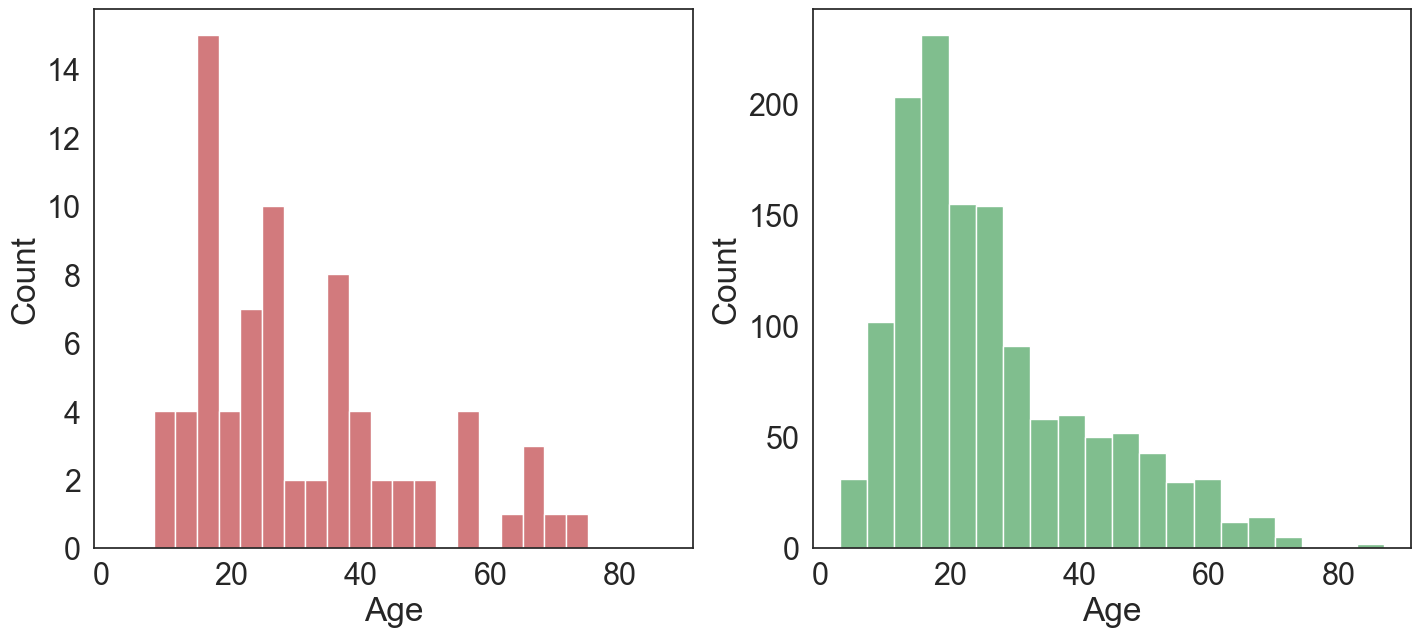

In [67]:
fig_a4, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
sns.histplot(data=sharks_df[sharks_df['Fatal (Y/N)'] == 'Y'], x='Age', bins=20, color='#c44e52', ax=ax1)
sns.histplot(data=sharks_df[sharks_df['Fatal (Y/N)'] == 'N'], x='Age', bins=20, color='#55a868', ax=ax2)

In [68]:
sharks_df[sharks_df['Age'] == sharks_df['Age'].max()]

,Case Number,Date,Year,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
1358,1985.08.22,22-Aug-1985,1985,USA,South Carolina,"Palmetto Dunes, Hilton Head, Beaufort County",Wading,M,87.0,N,East Coast


In [69]:
sharks_df[sharks_df['Age'] < 15]

,Case Number,Date,Year,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
7,2022.08.13,13-Aug-2022,2022,USA,Florida,"Looe Key, Monroe County",Snorkeling,M,10.0,N,East Coast
9,2022.07.27,27-Jul-2022,2022,USA,Florida,"Florida Keys, Monroe County",Lobstering,M,13.0,N,East Coast
49,2021.08.02,02-Aug-2021,2021,USA,Maryland,"Ocean City, Worcester County",Swimming,F,12.0,N,East Coast
54,2021.07.15,15-Jul-2021,2021,USA,Florida,"New Smyrna Beach, Volusia County",Boogie boarding,M,11.0,N,East Coast
55,2021.07.10.c,10-Jul-2021,2021,USA,Florida,"Bathtub Beach, Martin County",Playing,F,9.0,N,East Coast
...,...,...,...,...,...,...,...,...,...,...,...
1761,1920.06.29,29-Jun-1920,1920,USA,Florida,"Englewood Beach, Charlotte County",Swimming,M,13.0,N,East Coast
1774,1916.07.12.c,12-Jul-1916,1916,USA,New Jersey,"In Matawan Creek, off NJ Clay Company brickyar...",Swimming,M,12.0,N,East Coast
1776,1916.07.12.a,12-Jul-1916,1916,USA,New Jersey,"Matawan Creek, 10 miles from the sea, Monmouth...",Swimming,M,10.0,Y,East Coast
1779,1916.06.30,30-Jun-1916,1916,USA,New Jersey,"Atlantic City, Atlantic County",Swimming,M,11.0,N,East Coast


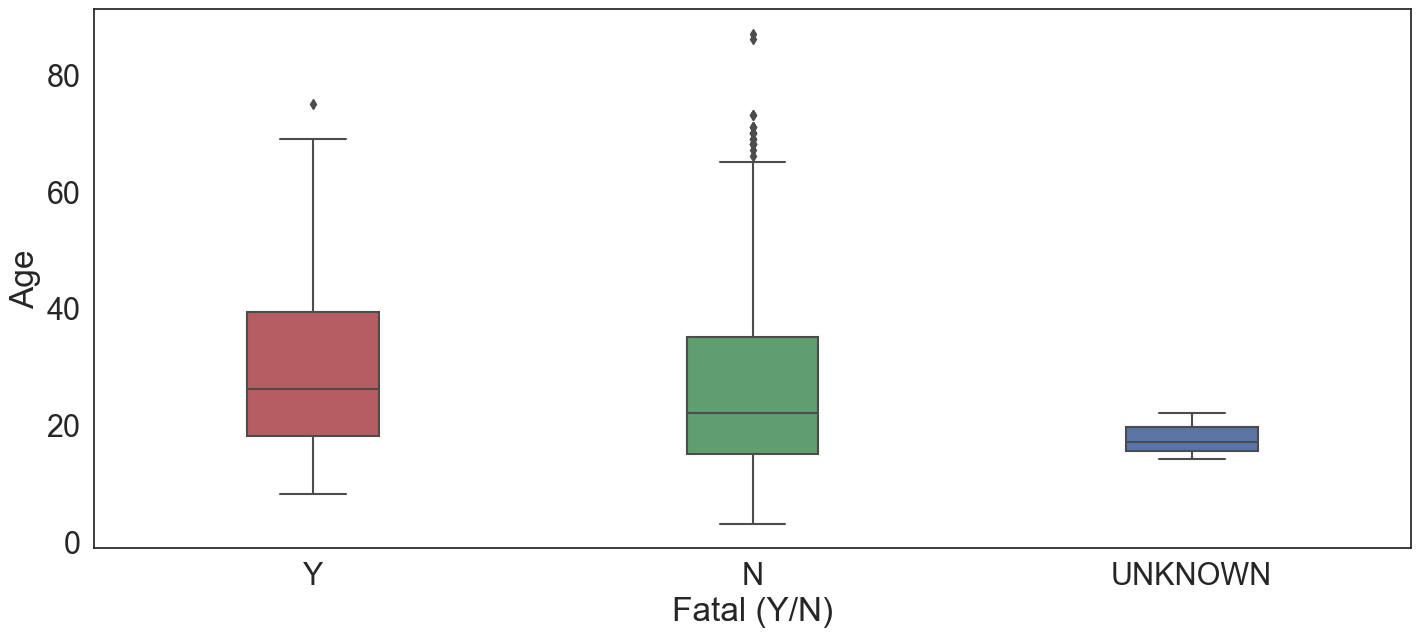

In [70]:
palette_diff_order = sns.color_palette(['#c44e52','#55a868','#4c72b0'])
fig_a5 = sns.boxplot(data=sharks_df, x='Fatal (Y/N)', y="Age", width=0.3, order=['Y', 'N', 'UNKNOWN'], palette=palette_diff_order)

# Vince and Jawad EDA Section

## Steps:
1. Create dataframe that gets the number of shark attacks per year
2. Create dataframe that gets mean/median sea level measurments per year
3. Combine both dataframes by year
4. Check to see if their is correlation by using linear regression

In [71]:
# create dataframe for # of shark attacks per year
num_shark_atks_per_year = sharks_df.groupby(['Year'])['Case Number'].size().reset_index(name='num_of_shark_attacks')
num_shark_atks_per_year

,Year,num_of_shark_attacks
0,1881,3
1,1882,1
2,1883,4
3,1884,1
4,1886,1
...,...,...
130,2018,31
131,2019,51
132,2020,40
133,2021,48


In [72]:
# create dataframe for mean/median of sea level dataframe

# create single column for sea level to avoid NaN values
def create_single_level_measurement(x):
    if not pd.isnull(x['Jason-3']):
        x['Sea Level'] = x['Jason-3']
    elif not pd.isnull(x['Jason-2']):
        x['Sea Level'] = x['Jason-2']
    elif not pd.isnull(x['Jason-1']):
        x['Sea Level'] = x['Jason-1']
    else:
        x['Sea Level'] = x['TOPEX/Poseidon']
    return x

sl_pacific_new = sl_pacific_df.apply(create_single_level_measurement, axis=1)
sl_pacific_new['year'] = sl_pacific_new['year'].astype(int)
sl_pacific_new = sl_pacific_new.drop(['TOPEX/Poseidon', 'Jason-1', 'Jason-2', 'Jason-3'], axis=1)

# calculate median for each year in the dataframe
sl_pacific_new = sl_pacific_new.groupby(['year'])['Sea Level'].median().reset_index(name='median_sea_level')

In [73]:
# sl_pacific_new['sqrt'] = stats.boxcox(sl_pacific_new['median_sea_level'])[0]
sl_pacific_new 
# sns.histplot(data=sl_pacific_new, x='sqrt', kde=True)

,year,median_sea_level
0,1992,4.145
1,1993,-9.935
2,1994,-1.340
3,1995,-12.335
4,1996,-7.940
5,1997,-4.160
6,1998,-11.830
7,1999,6.590
8,2000,4.175
9,2001,3.015


In [74]:
# merge both dataframes
pacific_sharks_merged = pd.merge(sl_pacific_new, num_shark_atks_per_year, how='inner', left_on='year', right_on='Year')
pacific_sharks_merged = pacific_sharks_merged.drop(['Year'], axis=1)
pacific_sharks_merged

,year,median_sea_level,num_of_shark_attacks
0,1992,4.145,18
1,1993,-9.935,20
2,1994,-1.340,19
3,1995,-12.335,41
4,1996,-7.940,24
5,1997,-4.160,27
6,1998,-11.830,24
7,1999,6.590,31
8,2000,4.175,46
9,2001,3.015,52


In [75]:
# run OLS
outcome, predictors = patsy.dmatrices('num_of_shark_attacks ~ median_sea_level', pacific_sharks_merged)
mod = sm.OLS(outcome, predictors)
result = mod.fit()

In [76]:
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     num_of_shark_attacks   R-squared:                       0.200
Model:                              OLS   Adj. R-squared:                  0.173
Method:                   Least Squares   F-statistic:                     7.264
Date:                  Tue, 15 Nov 2022   Prob (F-statistic):             0.0116
Time:                          16:06:40   Log-Likelihood:                -117.32
No. Observations:                    31   AIC:                             238.6
Df Residuals:                        29   BIC:                             241.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

<AxesSubplot: xlabel='median_sea_level', ylabel='num_of_shark_attacks'>

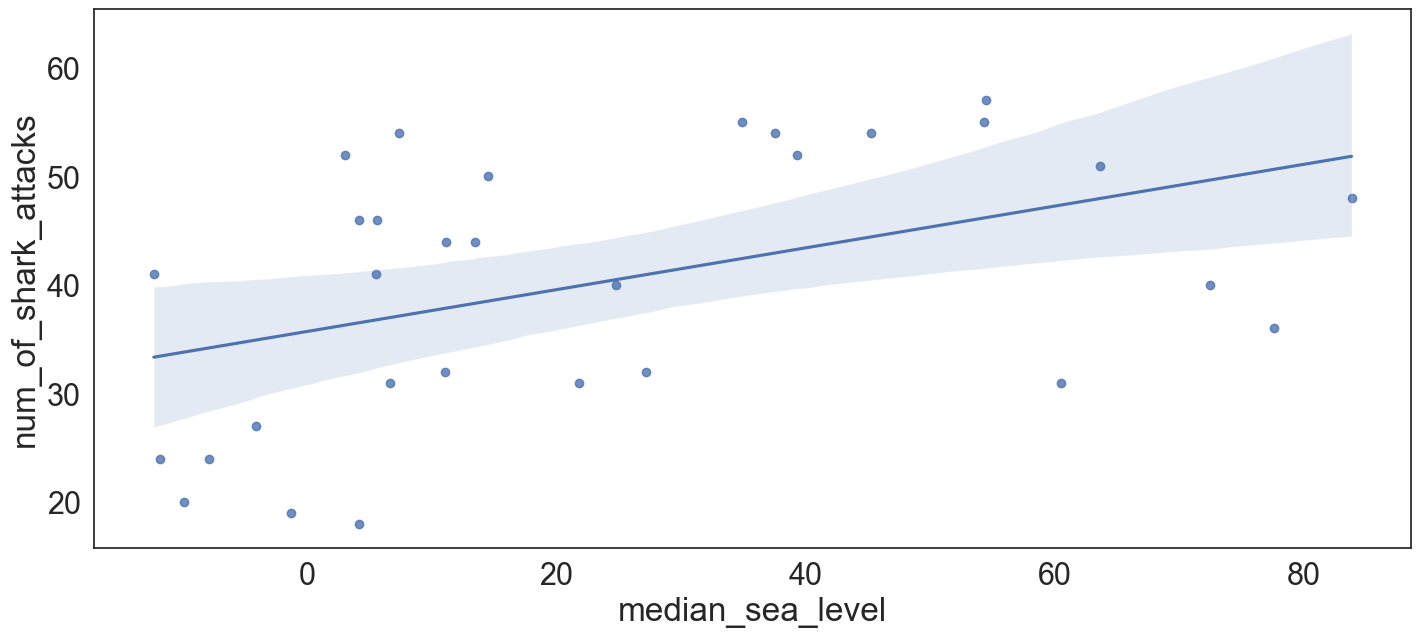

In [77]:
sns.regplot(data=pacific_sharks_merged, x='median_sea_level', y='num_of_shark_attacks')

Do same procedure above, but with atlantic sea level measurements

In [78]:
sl_atlantic_new = sl_atlantic_df.apply(create_single_level_measurement, axis=1)
sl_atlantic_new['year'] = sl_atlantic_new['year'].astype(int)
sl_atlantic_new = sl_atlantic_new.drop(['TOPEX/Poseidon', 'Jason-1', 'Jason-2', 'Jason-3'], axis=1)

# calculate median for each year in the dataframe
sl_atlantic_new = sl_atlantic_new.groupby(['year'])['Sea Level'].median().reset_index(name='median_sea_level')

In [79]:
# merge both dataframes
atlantic_sharks_merged = pd.merge(sl_atlantic_new, num_shark_atks_per_year, how='inner', left_on='year', right_on='Year')
atlantic_sharks_merged = atlantic_sharks_merged.drop(['Year'], axis=1)
atlantic_sharks_merged

,year,median_sea_level,num_of_shark_attacks
0,1992,-13.930,18
1,1993,-17.020,20
2,1994,-15.375,19
3,1995,-3.280,41
4,1996,-7.925,24
5,1997,-8.110,27
6,1998,1.160,24
7,1999,15.130,31
8,2000,15.060,46
9,2001,-1.620,52


<AxesSubplot: xlabel='median_sea_level', ylabel='num_of_shark_attacks'>

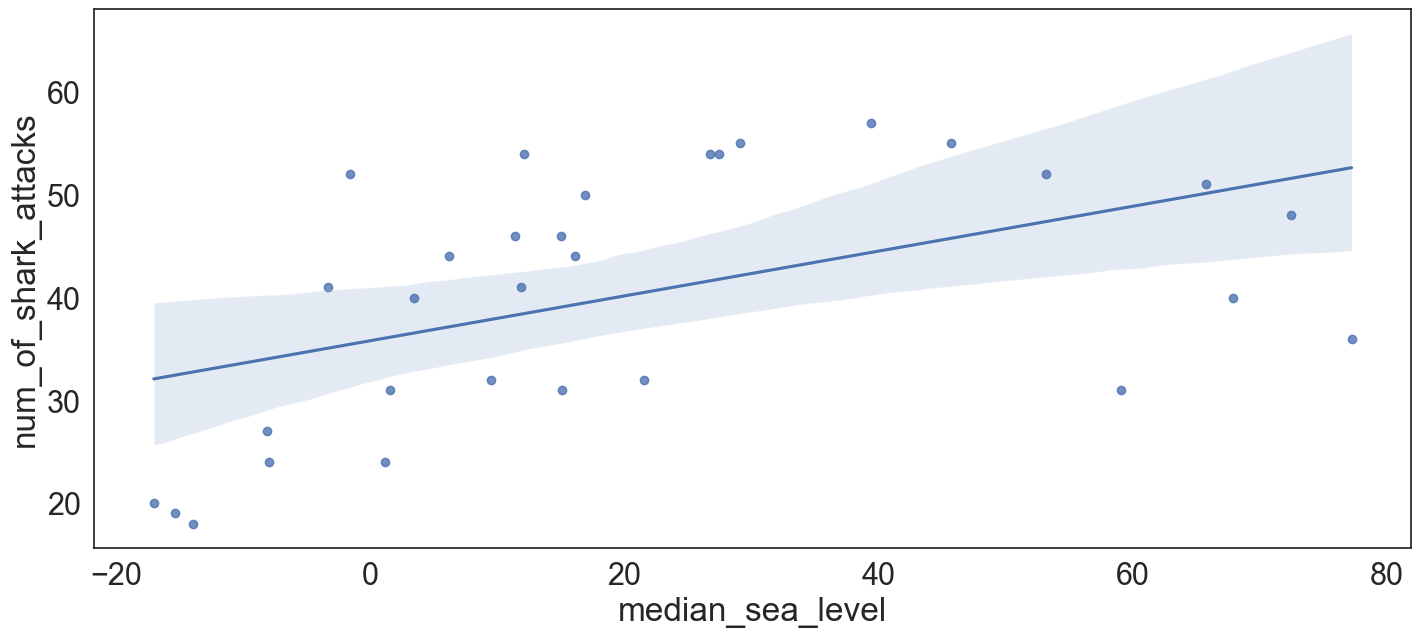

In [80]:
# plot data and linear regression model fit
sns.regplot(data=atlantic_sharks_merged, x='median_sea_level', y='num_of_shark_attacks')

                             year  temperature_anomaly_cel
year                     1.000000                 0.826823
temperature_anomaly_cel  0.826823                 1.000000


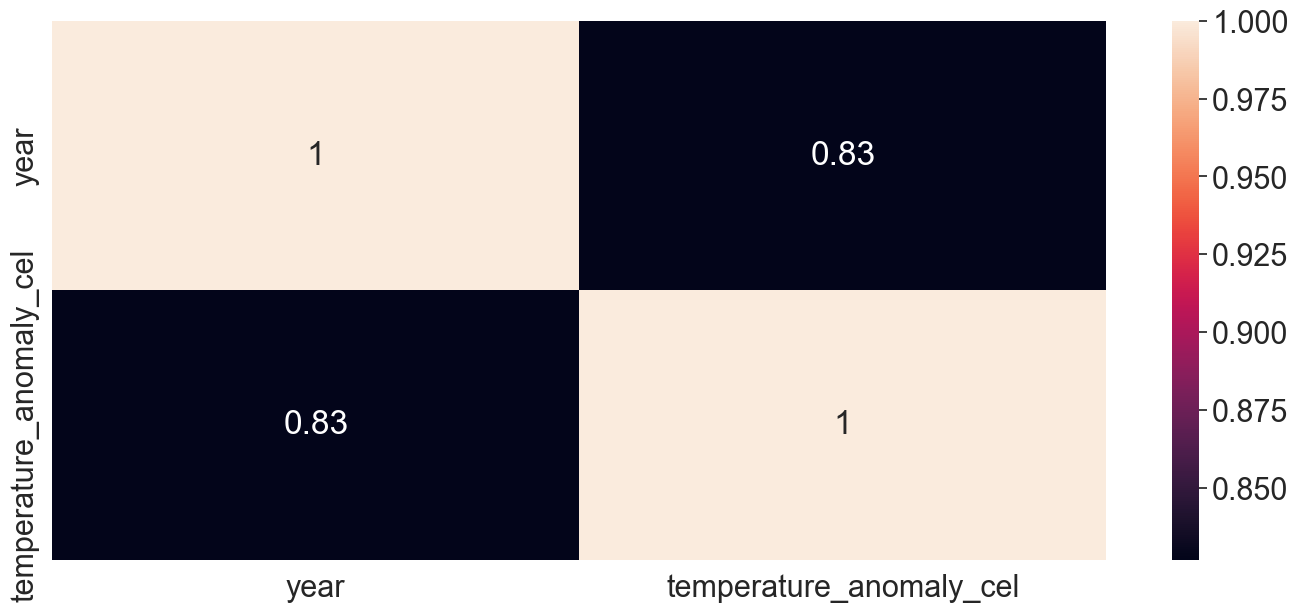

In [81]:
#setting up a list of all the relavent years (1881 - 2022)
relevantTimeFrame = []
for i in range(1881,2023):
    relevantTimeFrame.append(i)
#creating df to store shark attacks per year
y = pd.DataFrame(index = relevantTimeFrame)
#organizing the shark attack data and puttign it into the relevantTimeFrame df
y['Shark attack per year'] = sharks_df['Year'].value_counts()
y = y.iloc[:-1]
temp = temp_df.iloc[1:]
y['Shark attack per year'] = y['Shark attack per year'].fillna(0)
#setting up DF that be tested for correlation
correlationDF = temp.set_index('year')
# wrangling data into same DF
extractedSharkData= y['Shark attack per year']
correlationDF = correlationDF.join(extractedSharkData)
#running test and plotting results
Shark_Correlation = temp.corr()
print(Shark_Correlation)
sns.heatmap(Shark_Correlation, annot=True)
plt.show()

<AxesSubplot: xlabel='Year', ylabel='Count'>

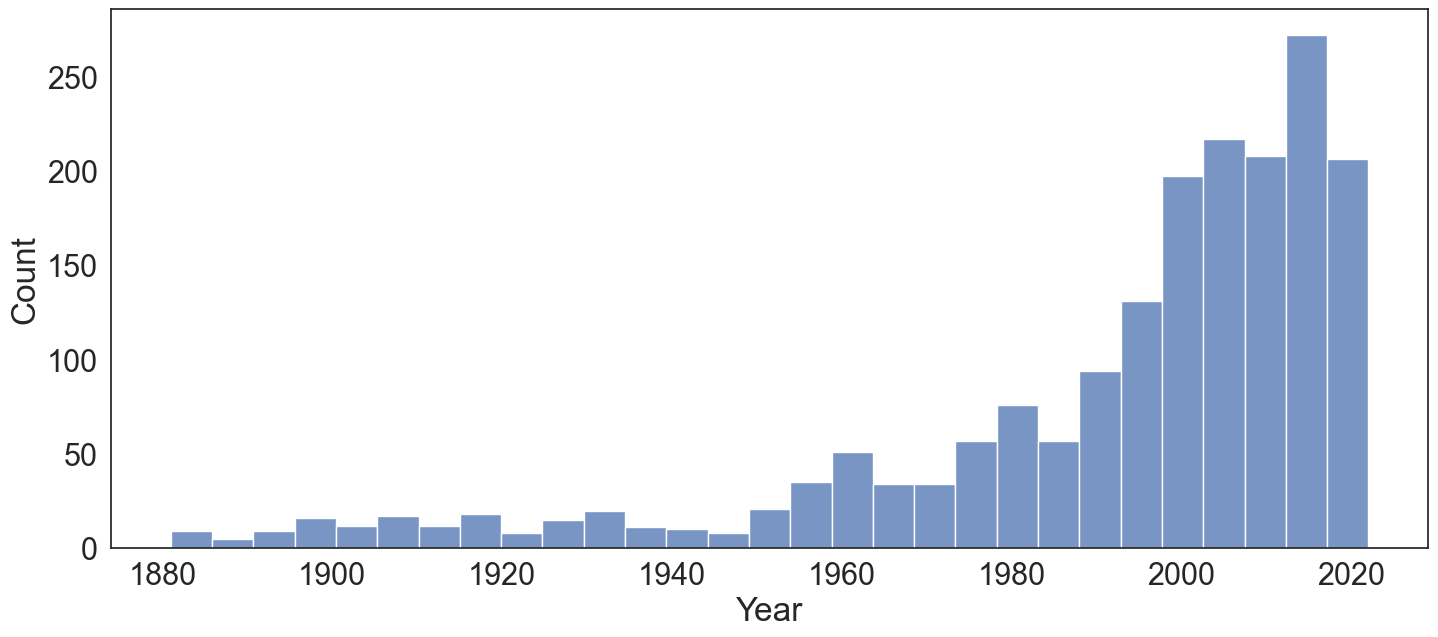

In [82]:
#shark attacks over the years
sns.histplot(data = sharks_df['Year'])

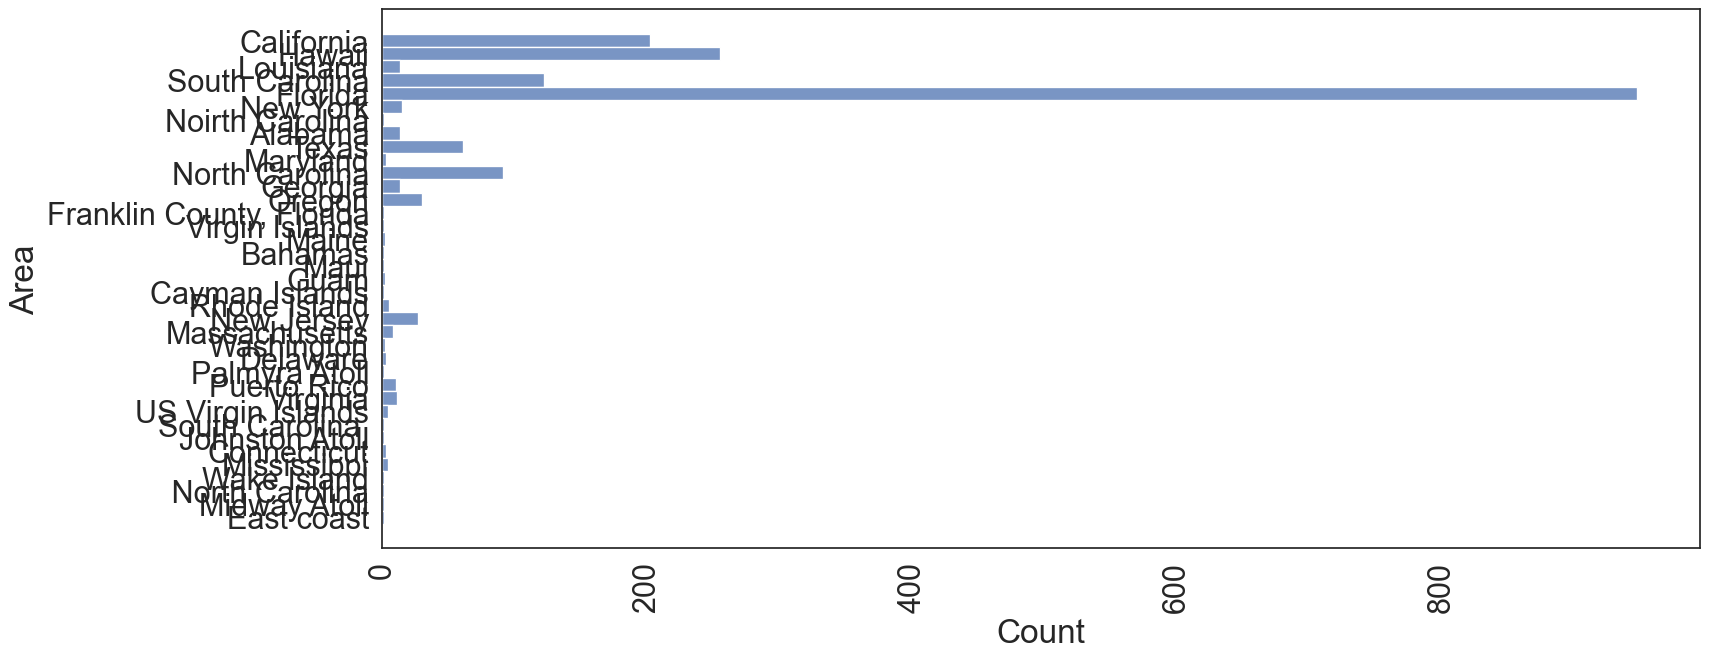

In [83]:
sns.histplot(data = sharks_df, y = 'Area')
plt.xticks(rotation= 90)
f1 = plt.gcf()

<AxesSubplot: xlabel='West/East Coast', ylabel='count'>

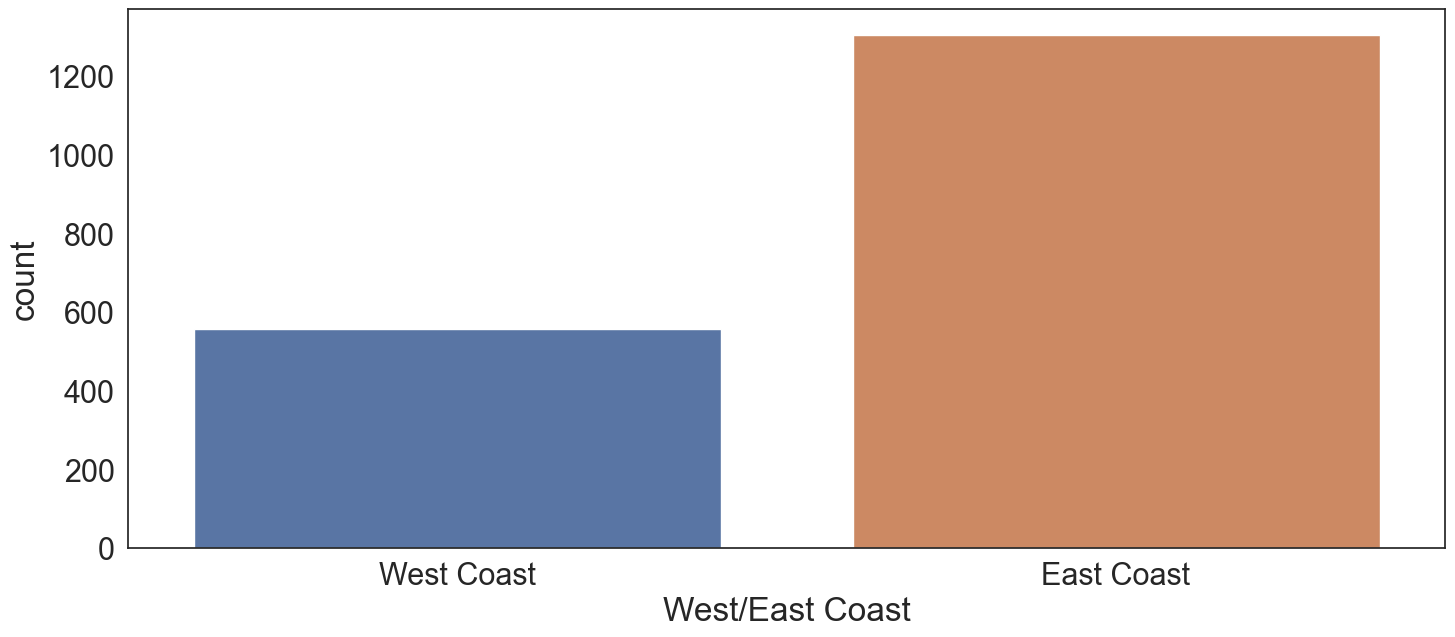

In [84]:
# shark attacks on the east coast vs the west coast
sns.countplot(data = sharks_df, x= sharks_df['West/East Coast'])

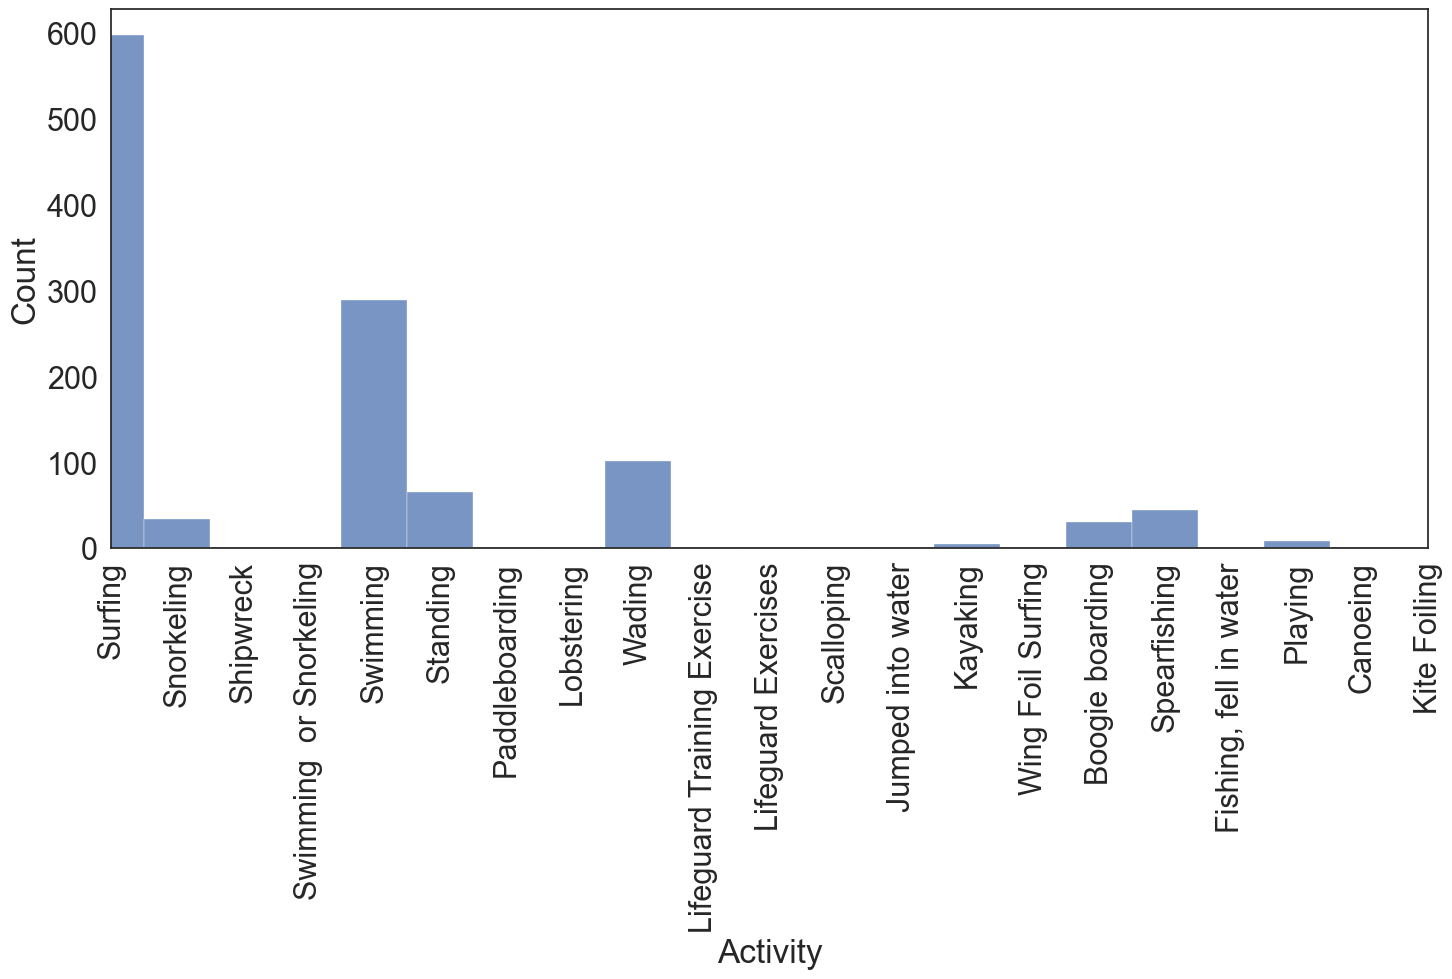

In [85]:
# activites being done  while being attacked
sns.histplot(data = sharks_df, x = 'Activity')
plt.xticks( rotation = 90)
plt.xlim(0, 20)
f1 = plt.gcf()